# Smart Logistics System - Data Analysis

This notebook performs exploratory data analysis and feature engineering on the DataCo Supply Chain dataset.

In [19]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
            .appName('gestion logistique')\
            .config('spark.some.config.option' , 'some-value')\
                .getOrCreate()


## 1. Setup and Data Loading

In [20]:
df = spark.read.csv('DataCoSupplyChainDataset.csv' , header=True , inferSchema=True)
df.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

## 2. Initial Data Exploration

In [21]:
from pyspark.sql.functions import col, expr

numeric_cols = [
    "Days for shipping (real)",
    "Days for shipment (scheduled)",
    "Benefit per order",
    "Sales per customer",
    "Order Item Product Price",
    "Order Item Profit Ratio",
    "Order Item Total"
]

for c in numeric_cols:
    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    
    print(f"Column: {c}, Lower bound: {lower}, Upper bound: {upper}")
    
    outliers = df.filter((col(c) < lower) | (col(c) > upper))
    print(f"Number of outliers in {c}: {outliers.count()}")

Column: Days for shipping (real), Lower bound: -7.0, Upper bound: 14.0
Number of outliers in Days for shipping (real): 0
Column: Days for shipment (scheduled), Lower bound: -4.0, Upper bound: 10.0
Number of outliers in Days for shipment (scheduled): 0
Column: Days for shipment (scheduled), Lower bound: -4.0, Upper bound: 10.0
Number of outliers in Days for shipment (scheduled): 0
Column: Benefit per order, Lower bound: -163.34999656200003, Upper bound: 233.40999554900003
Column: Benefit per order, Lower bound: -163.34999656200003, Upper bound: 233.40999554900003
Number of outliers in Benefit per order: 8167
Number of outliers in Benefit per order: 8167
Column: Sales per customer, Lower bound: -321.92002850000006, Upper bound: 671.8700331
Number of outliers in Sales per customer: 467
Column: Sales per customer, Lower bound: -321.92002850000006, Upper bound: 671.8700331
Number of outliers in Sales per customer: 467
Column: Order Item Product Price, Lower bound: -399.9700165, Upper bound:

### 2.2 Check for Missing Values

In [22]:
from pyspark.sql.functions import col, isnan, when, count , sum

null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

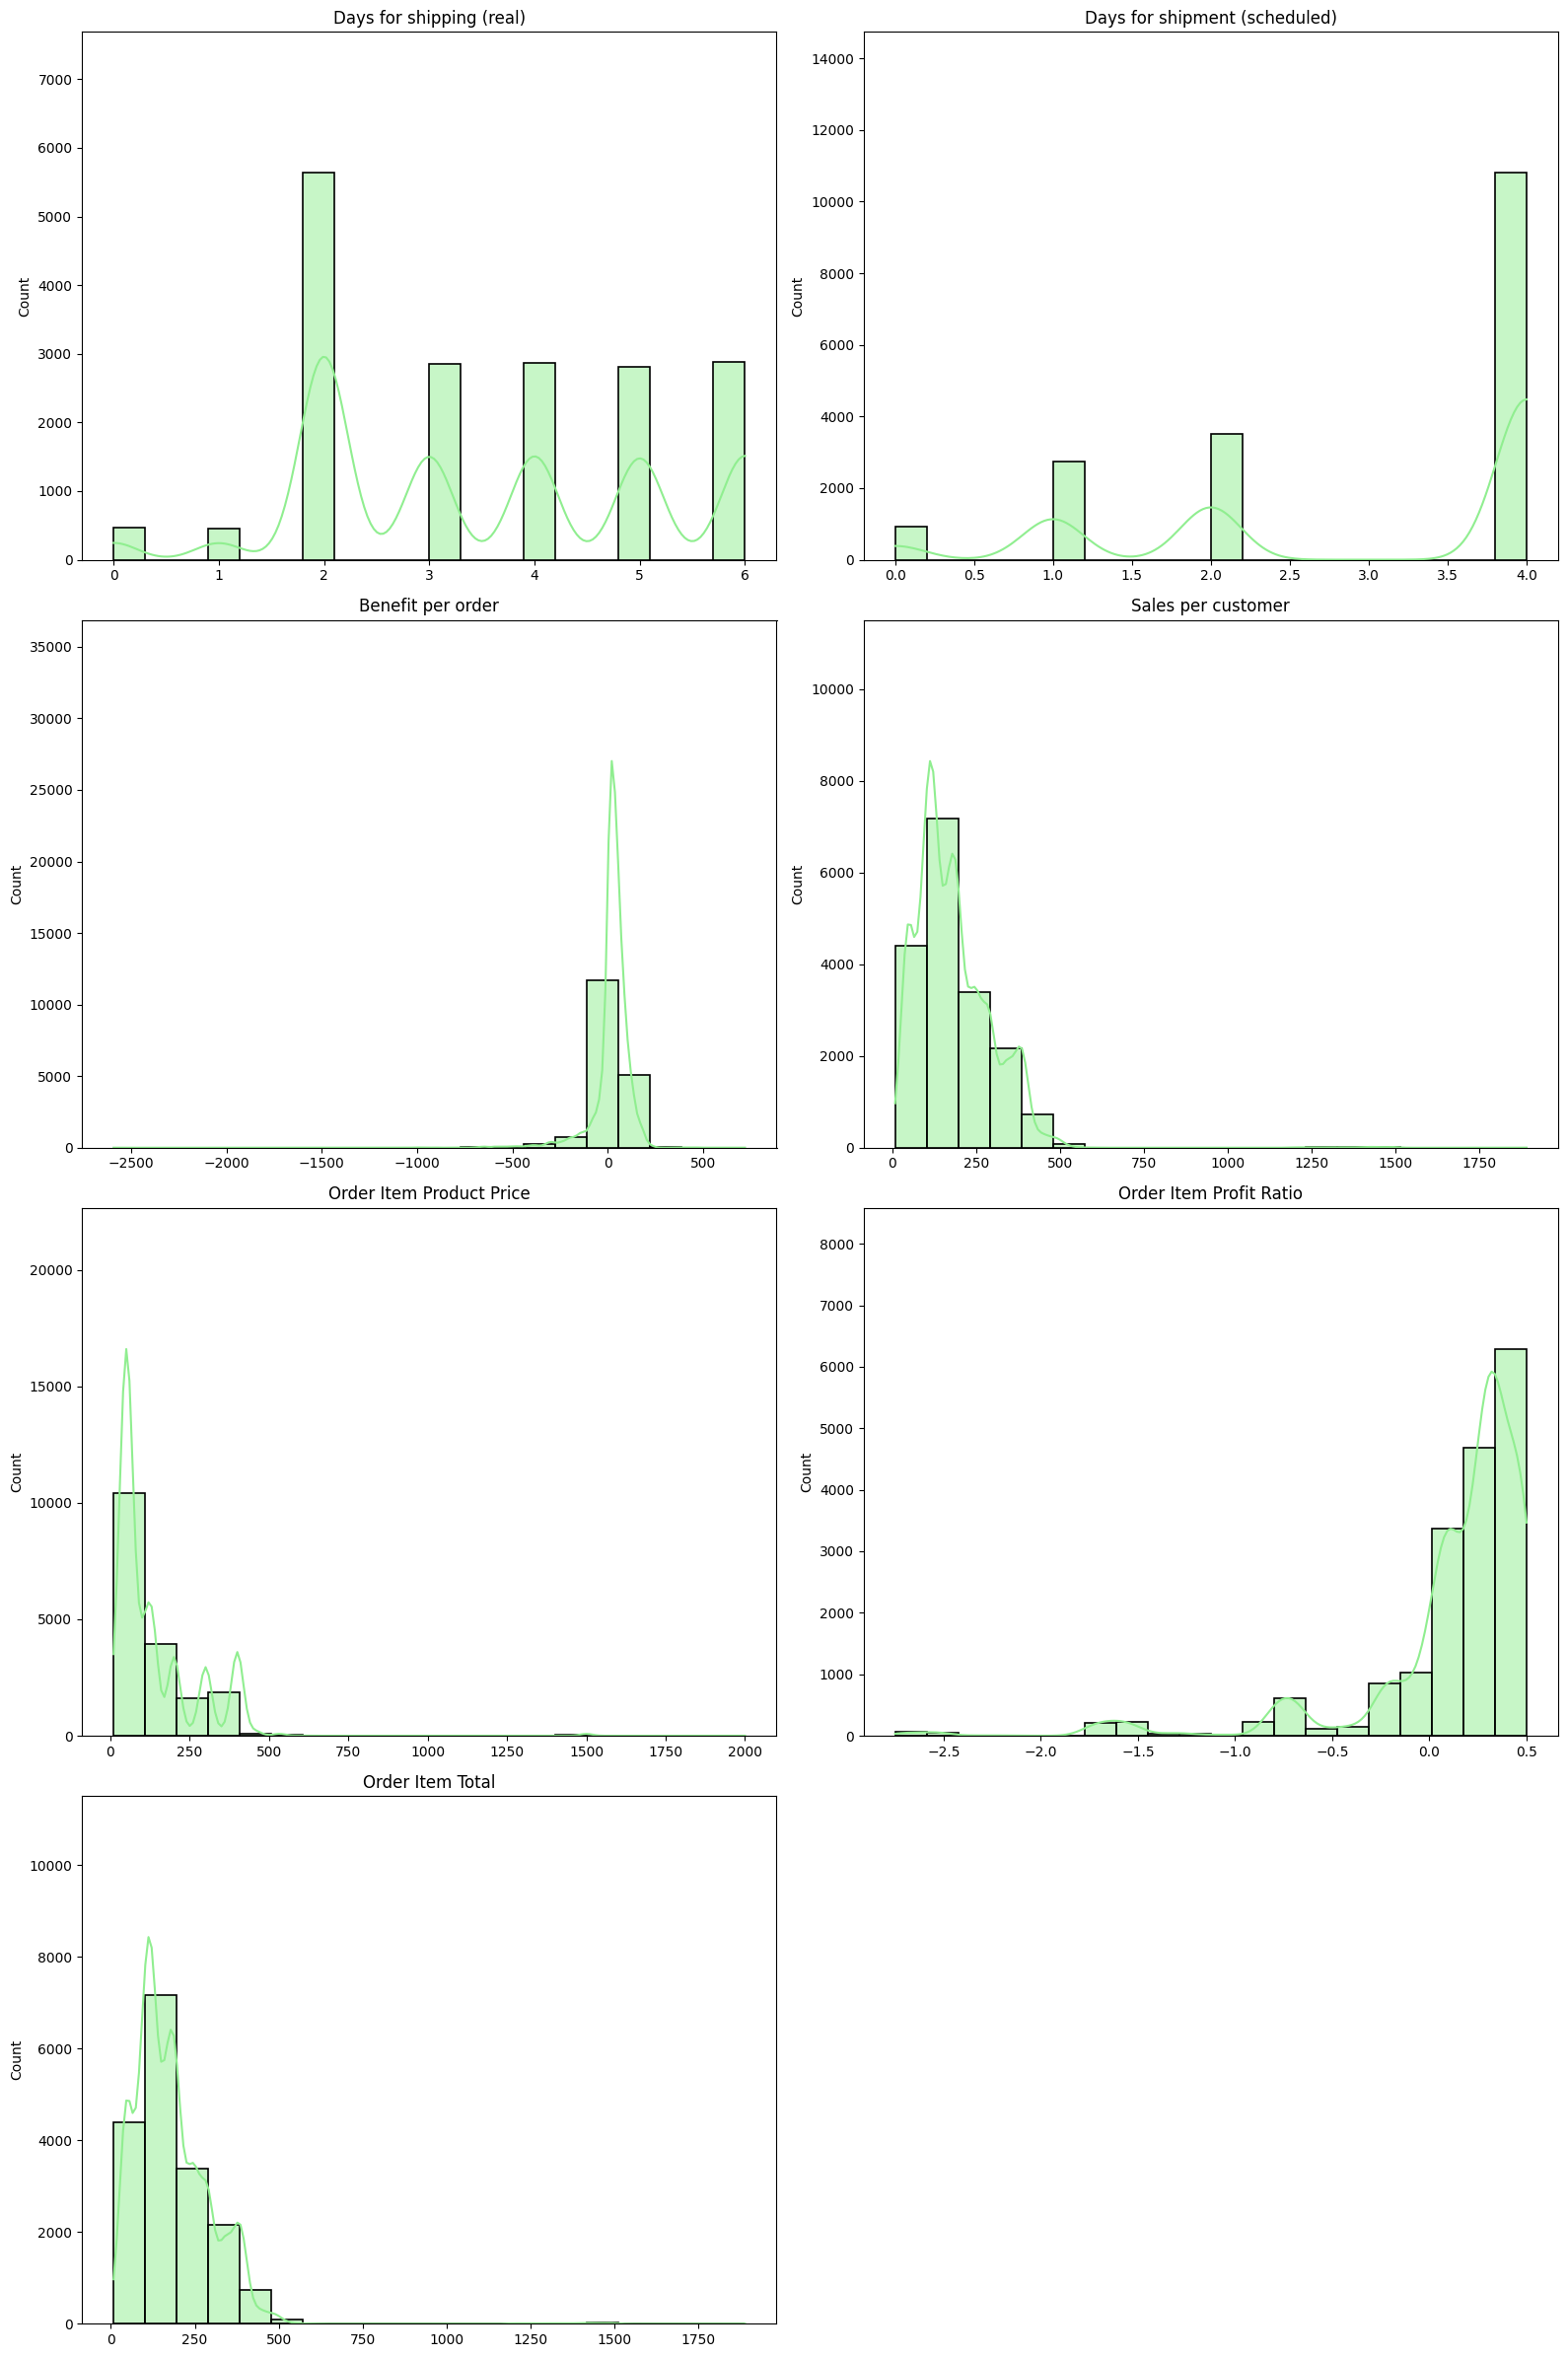

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


df_sample = df.sample(fraction=0.1, seed=42).toPandas()

n_cols = 2  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(16, n_rows * 6))  
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        df_sample[col],
        bins=20,
        kde=True,
        color="lightgreen",
        edgecolor="black",
        linewidth=1.2
    )
    plt.title(col, fontsize=12)
    plt.xlabel("")
    plt.ylabel("Count")
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.3)  

plt.tight_layout()
plt.show()

### 2.3 Distribution Visualization of Numeric Features

## 3. Data Cleaning

In [24]:
# df_filled = df.na.fill(0)
df = df.drop("Product Description" , "Order Zipcode")

df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+-------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+-----------------+------------------+------+--------------+-------------+-----------------+-----------------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+-------------------+--------------------+--------------------+-----------------+--------------+--------------------------+--------------+
|summary|    Type|Days for shipping (real)|D

In [25]:
from pyspark.sql.functions import col, isnan, when, count , sum

null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()




+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+---------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Category Id|Category Name|Customer C

### 3.1 Verify Missing Values After Cleaning

In [26]:
df.count()

180519

### 3.2 Feature Selection - Drop Unnecessary Columns

In [27]:
columns_to_drop = ["Customer Email" , "Customer Fname" , "Customer Id" , "Customer Lname" , "Customer Password" , "Customer Segment" , "Customer State" , "Customer Street" , "Customer Zipcode" , "Department Name" ,  "Order Customer Id" , "Order Item Product Price" , "Order Item Profit Ratio"   , "Order Profit Per Order"  , "Product Image" , "Product Name" , "Order Item Cardprod Id" , "Order Item Discount" , "Order Item Id" , "Product Card Id"  , "Sales"  , "Departement id" , "Category id" , "Category name" , "Order item total" , "Order id"] 

len(columns_to_drop)

26

In [28]:
df_cleaned = df.drop(*columns_to_drop)
df_cleaned.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-------------+----------------+-------------+-----------+------------+------------+----------+-------------+-----------------------+------------------------+-------------------+--------------+---------------+---------------+-------------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|Customer City|Customer Country|Department Id|   Latitude|   Longitude|      Market|Order City|Order Country|order date (DateOrders)|Order Item Discount Rate|Order Item Quantity|  Order Region|    Order State|   Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)| Shipping Mode|
+--------+------------------------+-----------------------------+-----------------+---------

## 4. Exploratory Data Analysis (EDA)

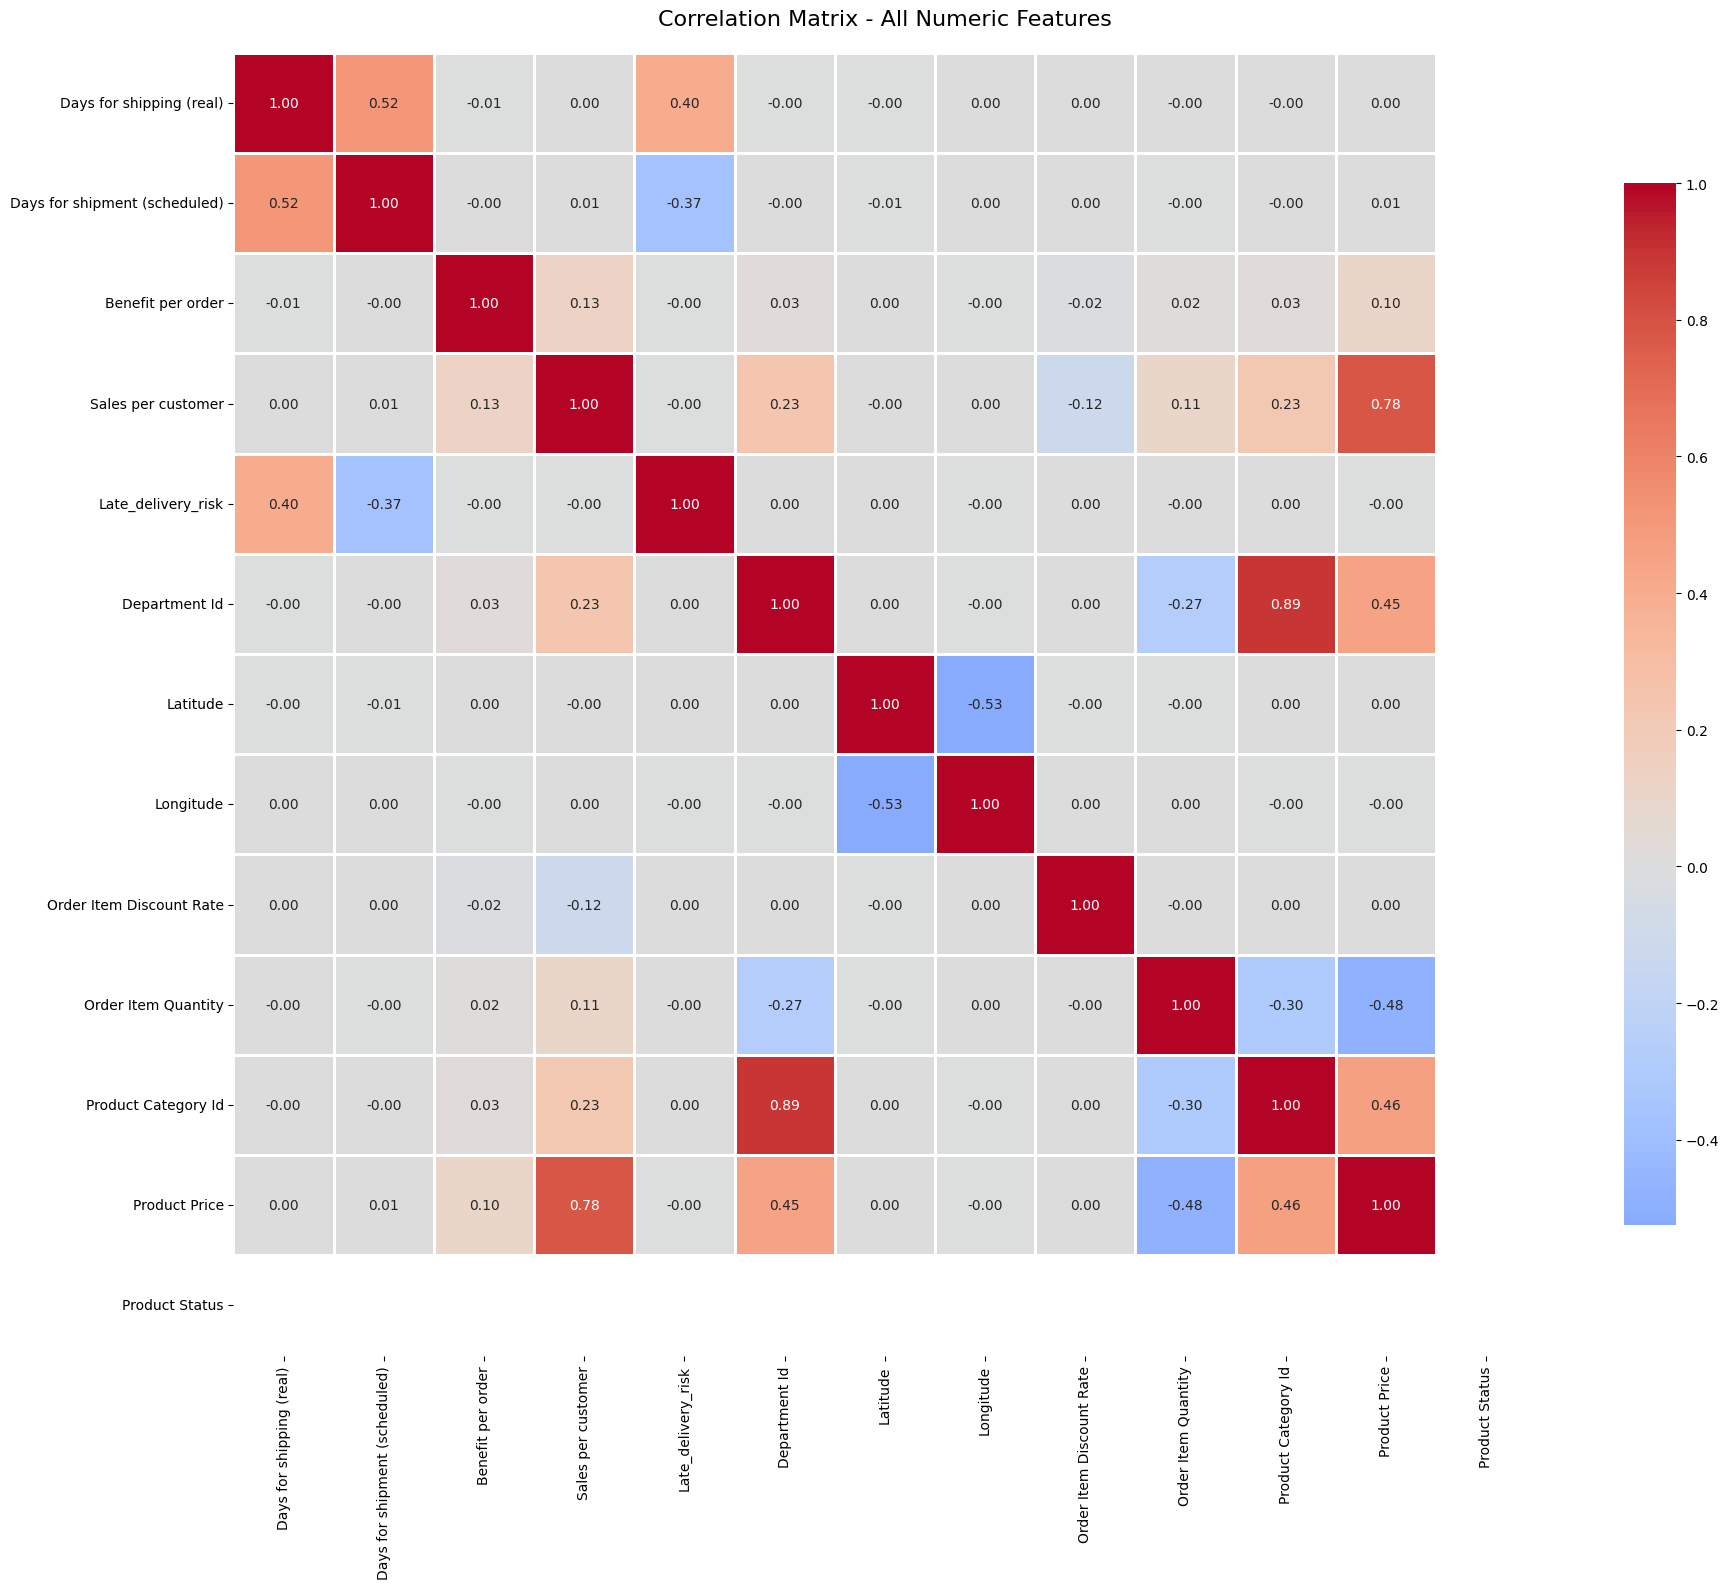

In [29]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_pandas = df_cleaned.toPandas()


numeric_df = df_pandas.select_dtypes(include=['int', 'float', 'double'])


correlation_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Numeric Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### 4.1 Correlation Matrix - All Numeric Features

In [30]:
from pyspark.sql.functions import col

duplicate_counts = (
    df_cleaned.groupBy(df_cleaned.columns)
    .count()
    .filter(col("count") > 1)
)

duplicate_counts.show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+-----------------------+------------------------+-------------------+------------+-----------+------------+-------------------+-------------+--------------+--------------------------+-------------+-----+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Customer City|Customer Country|Department Id|Latitude|Longitude|Market|Order City|Order Country|order date (DateOrders)|Order Item Discount Rate|Order Item Quantity|Order Region|Order State|Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)|Shipping Mode|count|
+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-

In [31]:
duplicate_counts.show()

numeric_types = ['int', 'float', 'double', 'decimal']

numeric_columns = [col for col , type in df_cleaned.dtypes if type in numeric_types]
numeric_columns.remove("Late_delivery_risk")
numeric_columns


date_columns = ["shipping date (DateOrders)" , "order date (DateOrders)"]

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+-----------------------+------------------------+-------------------+------------+-----------+------------+-------------------+-------------+--------------+--------------------------+-------------+-----+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Customer City|Customer Country|Department Id|Latitude|Longitude|Market|Order City|Order Country|order date (DateOrders)|Order Item Discount Rate|Order Item Quantity|Order Region|Order State|Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)|Shipping Mode|count|
+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-

## 5. Feature Engineering

In [32]:
numeric_types = ['int', 'float', 'double', 'decimal']

numeric_columns = [col for col , type in df_cleaned.dtypes if type in numeric_types]
numeric_columns.remove("Late_delivery_risk")
numeric_columns

date_columns = ["shipping date (DateOrders)" , "order date (DateOrders)"]

In [33]:
from pyspark.ml.feature import StandardScaler, OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp

df_with_dates = df_cleaned.withColumn(
    "order_date_timestamp", 
    unix_timestamp("order date (DateOrders)", "M/d/yyyy H:mm")
).withColumn(
    "shipping_date_timestamp", 
    unix_timestamp("shipping date (DateOrders)", "M/d/yyyy H:mm")
)

df_with_dates = df_with_dates.drop("order date (DateOrders)", "shipping date (DateOrders)")

numeric_columns_with_dates = numeric_columns + ["order_date_timestamp", "shipping_date_timestamp"]
categorical_columns = [col for col in df_with_dates.columns if (col not in numeric_columns_with_dates) and (col != "Late_delivery_risk")]

string_indexer = StringIndexer(
    inputCols=categorical_columns,
    outputCols=[col + "_index" for col in categorical_columns],
    handleInvalid="keep"
)

indexed_col_names = [col + "_index" for col in categorical_columns]
encoder = OneHotEncoder(
    inputCols=indexed_col_names,
    outputCols=[col + "_vec" for col in indexed_col_names]
)

assembler = VectorAssembler(
    inputCols=numeric_columns_with_dates,
    outputCol="unscaled_features"
)

scaler = StandardScaler(
    inputCol="unscaled_features",
    outputCol="scaled_numeric_features" 
)

final_feature_cols = [col + "_vec" for col in indexed_col_names] + ["scaled_numeric_features"]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

preprocessing_pipeline = Pipeline(
    stages=[
        string_indexer,
        encoder,
        assembler,
        scaler,
        final_assembler
    ]
)

preprocessing_model = preprocessing_pipeline.fit(df_with_dates)

df_ready_for_ml = preprocessing_model.transform(df_with_dates)

df_ready_for_ml.select("features", "Late_delivery_risk").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                              |Late_delivery_risk|
+-----------------------------------------------------------------------------------------------------------------------------------------------

### 5.1 Numeric Feature Scaling and Categorical Encoding

In [34]:
from pyspark.ml.stat import Correlation

print("\n--- Calculating Correlation Matrix ---")

corr_assembler = VectorAssembler(
    inputCols=indexed_col_names,
    outputCol="corr_features"
)

df_corr_vector = corr_assembler.transform(df_ready_for_ml).select("corr_features")

print("Calculating matrix...")
corr_matrix_df = Correlation.corr(df_corr_vector, "corr_features", "pearson")

corr_matrix = corr_matrix_df.collect()[0][0]

print("\nSpark Correlation Matrix (as a dense matrix):")
print(corr_matrix)

print("\nColumns in the matrix (in order):")
for i, col in enumerate(indexed_col_names):
    print(f"{i}: {col}")


--- Calculating Correlation Matrix ---
Calculating matrix...



Spark Correlation Matrix (as a dense matrix):
DenseMatrix([[ 1.00000000e+00, -7.48051235e-03, -2.05205813e-03,
               1.01712965e-03, -8.22570054e-03, -6.61453954e-03,
              -5.16877887e-03, -5.18655800e-03, -9.59692044e-03,
               3.91862497e-01,  1.53155906e-04],
             [-7.48051235e-03,  1.00000000e+00, -2.98603466e-03,
               4.79621780e-04, -6.15473084e-04, -8.44693779e-03,
              -3.98125842e-03,  9.92614110e-04, -3.31067823e-03,
               2.72467320e-01, -1.80585268e-01],
             [-2.05205813e-03, -2.98603466e-03,  1.00000000e+00,
              -4.78063943e-01,  6.93878751e-03,  1.41225277e-03,
               4.10090040e-03,  5.90946022e-03, -2.11375881e-04,
               6.74622577e-03,  2.60973298e-03],
             [ 1.01712965e-03,  4.79621780e-04, -4.78063943e-01,
               1.00000000e+00, -1.11341552e-02, -2.09191475e-03,
              -6.00054824e-03, -6.59123660e-03, -3.64611504e-03,
              -3.18228018e

### 5.2 Correlation Analysis

In [35]:
encoded_feature_cols = [col + "_vec" for col in indexed_col_names]
final_cols = ["features"] + encoded_feature_cols + ["Late_delivery_risk"]

df_final = df_ready_for_ml.select(final_cols)
df_final.show(5)

+--------------------+--------------+-------------------------+-----------------------+--------------------------+----------------+--------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+------------------+
|            features|Type_index_vec|Delivery Status_index_vec|Customer City_index_vec|Customer Country_index_vec|Market_index_vec|Order City_index_vec|Order Country_index_vec|Order Region_index_vec|Order State_index_vec|Order Status_index_vec|Shipping Mode_index_vec|Late_delivery_risk|
+--------------------+--------------+-------------------------+-----------------------+--------------------------+----------------+--------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+------------------+
|(5478,[0,5,8,572,...| (4,[0],[1.0])|            (4,[1],[1.0])|        (563,[0],[1.0])|             (2,[1],[1.0])|   (5,[2],[1.0])|  (35

### 5.3 Visualize Correlation Matrix

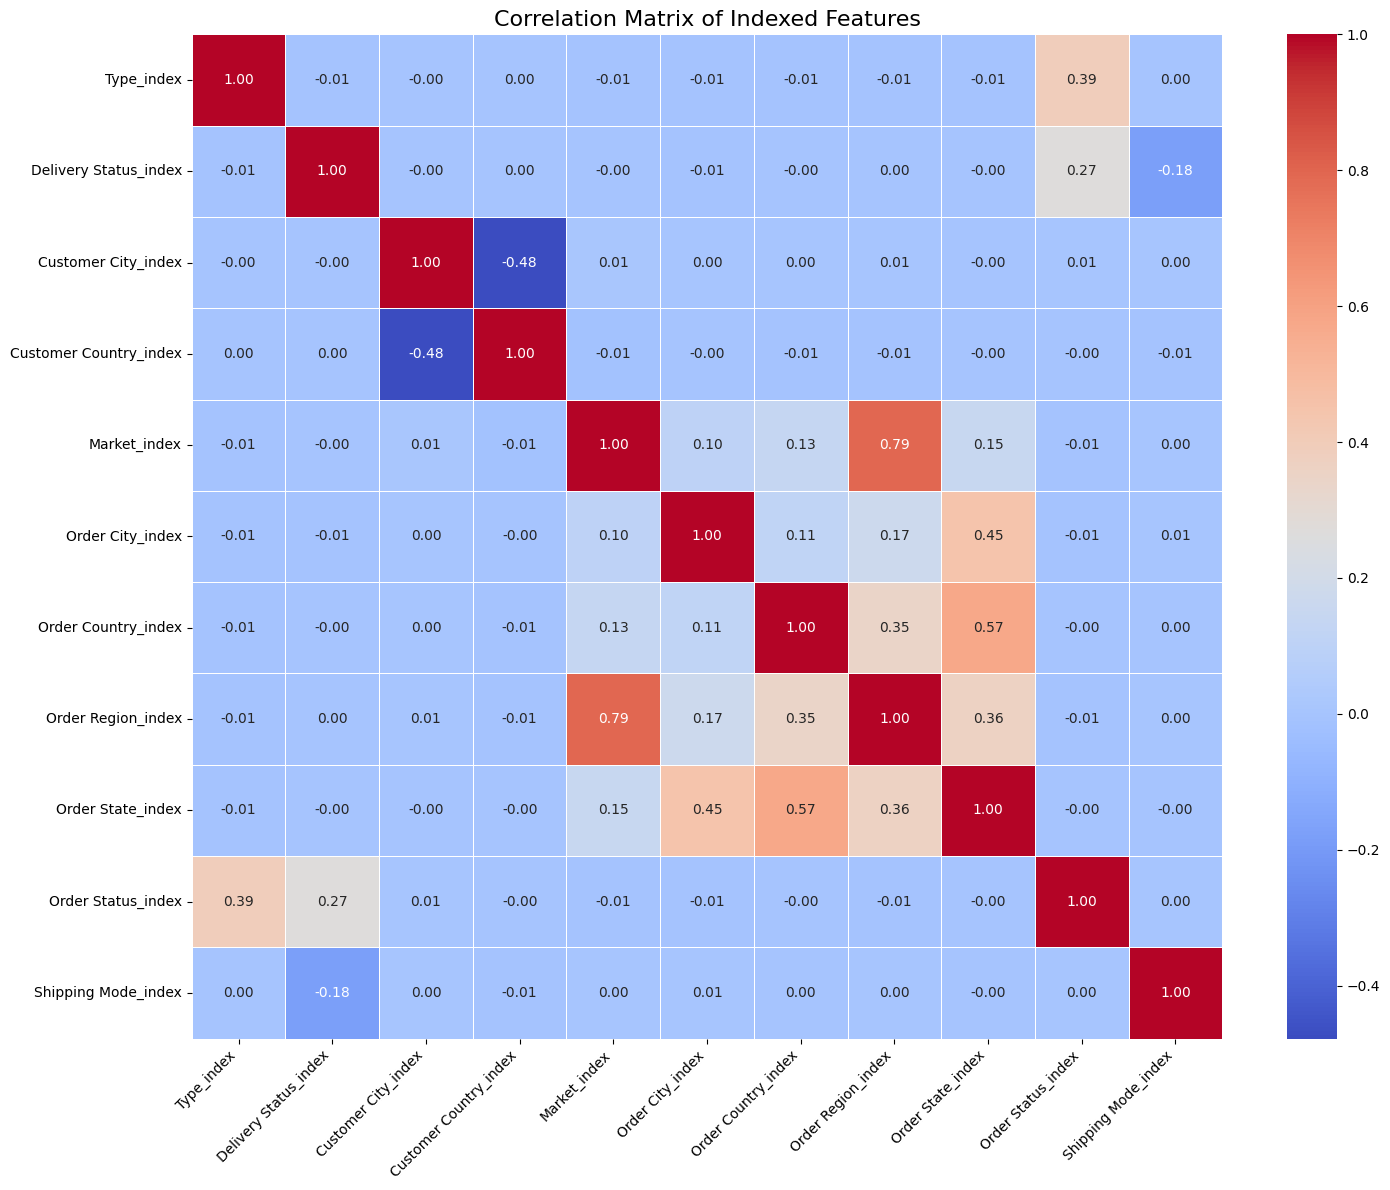

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

corr_array = corr_matrix.toArray()
pandas_df = pd.DataFrame(
    corr_array, 
    index=indexed_col_names, 
    columns=indexed_col_names
)

plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(
    pandas_df,
    annot=True,      
    fmt='.2f',      
    cmap='coolwarm',
    linewidths=.5   
)
plt.title('Correlation Matrix of Indexed Features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()

## 6. Final Feature Assembly

Combine all features into a single vector for modeling.

In [37]:
# The final features are already assembled in df_ready_for_ml
# Select only the features and label columns for modeling
df_ready = df_ready_for_ml.select("features", "Late_delivery_risk")

df_ready.show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                              |Late_delivery_risk|
+-----------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
from pyspark.sql.functions import col

print(f" the nupmber of high risk is : {df_ready.filter(col("Late_delivery_risk") == 1).count()}")
print(f" the nupmber of low risk is : {df_ready.filter(col("Late_delivery_risk") == 0).count()}")

 the nupmber of high risk is : 98977
 the nupmber of low risk is : 81542
 the nupmber of low risk is : 81542


In [39]:
(training_data , test_data) = df_ready.randomSplit([0.7 , 0.3] , seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="Late_delivery_risk")


(trainingData, testData) = df_ready.randomSplit([0.8, 0.2], seed=42)


lr_model = lr.fit(trainingData)


predictions = lr_model.transform(testData)


predictions.select("features", "Late_delivery_risk", "prediction", "probability").show(5, truncate=False)

25/11/11 23:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1091.1 KiB
25/11/11 23:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1092.2 KiB
25/11/11 23:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1091.2 KiB
25/11/11 23:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1092.2 KiB
25/11/11 23:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1091.2 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1092.3 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1092.3 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1091.2 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1092.3 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1091.2 KiB
25/11/11 23:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1092.3 KiB
25/11/11 23:36:10 WAR

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+----------+------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                |Late_delivery_risk|prediction|probability                               |
+-------------------------------